In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task
Write Python code to build, train, and evaluate an image classification model on the Kaggle butterfly dataset, and include code for inference.

## Load and preprocess data

### Subtask:
Load the dataset and preprocess it for model training.


**Reasoning**:
The subtask requires loading and preprocessing the dataset. This involves importing the dataset, loading the data, normalizing the pixel values, and reshaping the images to include a channel dimension. These steps can be combined into a single code block.



In [ ]:
import os

# Replace with the path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/GenAI/archive.zip'

# Replace with the desired directory to extract the files in Colab
extract_dir = '/content/dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
!unzip "{zip_file_path}" -d "{extract_dir}"

In [1]:
import pandas as pd

df_train = pd.read_csv('/content/dataset/Training_set.csv')
df_test = pd.read_csv('/content/dataset/Testing_set.csv')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_size = 64

encoder = LabelEncoder()
df_train['label_enc'] = encoder.fit_transform(df_train['label'])
num_classes = len(encoder.classes_)
encoder.classes_

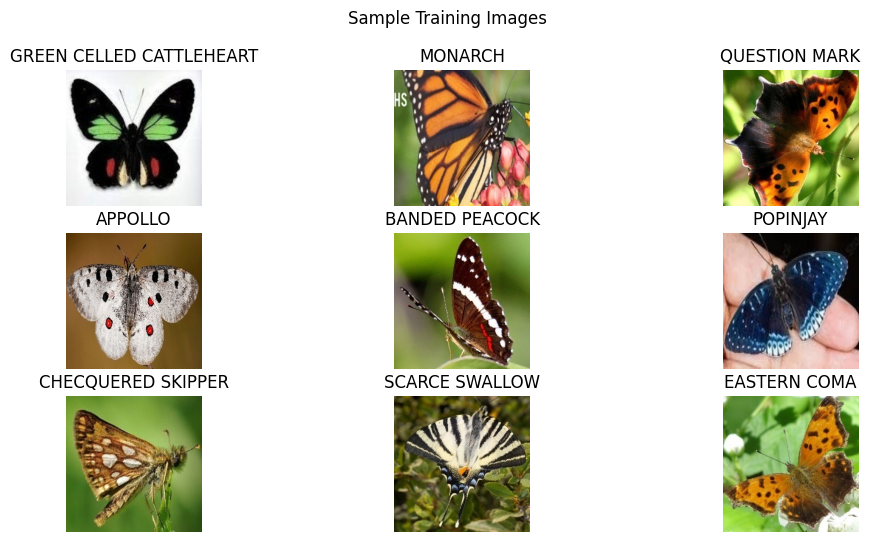

In [5]:
sample = df_train.sample(9, random_state=42)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample.itertuples()):
    img_path = os.path.join("/content/dataset", "train", row.filename)
    img = Image.open(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

In [6]:
def load_images(df, folder, train=True):
    images, labels = [], []
    for i in range(len(df)):
        img_path = os.path.join(folder, df.iloc[i ,0])
        img = load_img(img_path, target_size=(image_size, image_size))
        img = img_to_array(img) / 255.0
        images.append(img)

        if train:
            labels.append(df.iloc[i]['label_enc'])
    if train:
        return np.array(images), to_categorical(labels, num_classes=num_classes)
    else:
        return np.array(images)

In [7]:
X_train, y_train = load_images(df_train, os.path.join("/content/dataset", "train"), train=True)
X_test = load_images(df_test, os.path.join("/content/dataset", "test"), train=False)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

In [9]:
train_gen = datagen.flow(X_train, y_train, batch_size=8, subset='training')
val_gen   = datagen.flow(X_train, y_train, batch_size=8, subset='validation', shuffle=False)

## Build model

### Subtask:
Build a convolutional neural network (CNN) model for image classification.


In [10]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Clear any previous models to avoid conflicts
import tensorflow.keras.backend as K
K.clear_session()

model = Sequential([
    # First Conv Block with BatchNorm
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3), padding='same',
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Third Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal')
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,635,371 (17.68 MB)

 Trainable params: 4,633,899 (17.68 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(75, activation='softmax')
])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Compile and train model

### Subtask:
Compile the model with an appropriate optimizer and loss function, then train it on the preprocessed data.


**Reasoning**:
Compile and train the model using the specified optimizer, loss function, metrics, and data.



In [12]:
# 1. Compile the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=1
)

Epoch 1/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.0258 - loss: 6.4500 - val_accuracy: 0.1016 - val_loss: 4.8890
Epoch 2/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.0812 - loss: 4.9869 - val_accuracy: 0.1740 - val_loss: 4.1830
Epoch 3/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1089 - loss: 4.6027 - val_accuracy: 0.2063 - val_loss: 3.8819
Epoch 4/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.1159 - loss: 4.4915 - val_accuracy: 0.0108 - val_loss: 125.1918
Epoch 5/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1504 - loss: 4.1914 - val_accuracy: 0.1917 - val_loss: 3.9837
Epoch 6/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.1664 - loss: 4.1824 - val_accuracy: 0.2340 - val_loss: 3.6768
Epoch 7/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1945 - loss: 3.9499 - val_accuracy: 0.1493 - val_loss: 4.2714
Epoch 8/500
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1485 - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


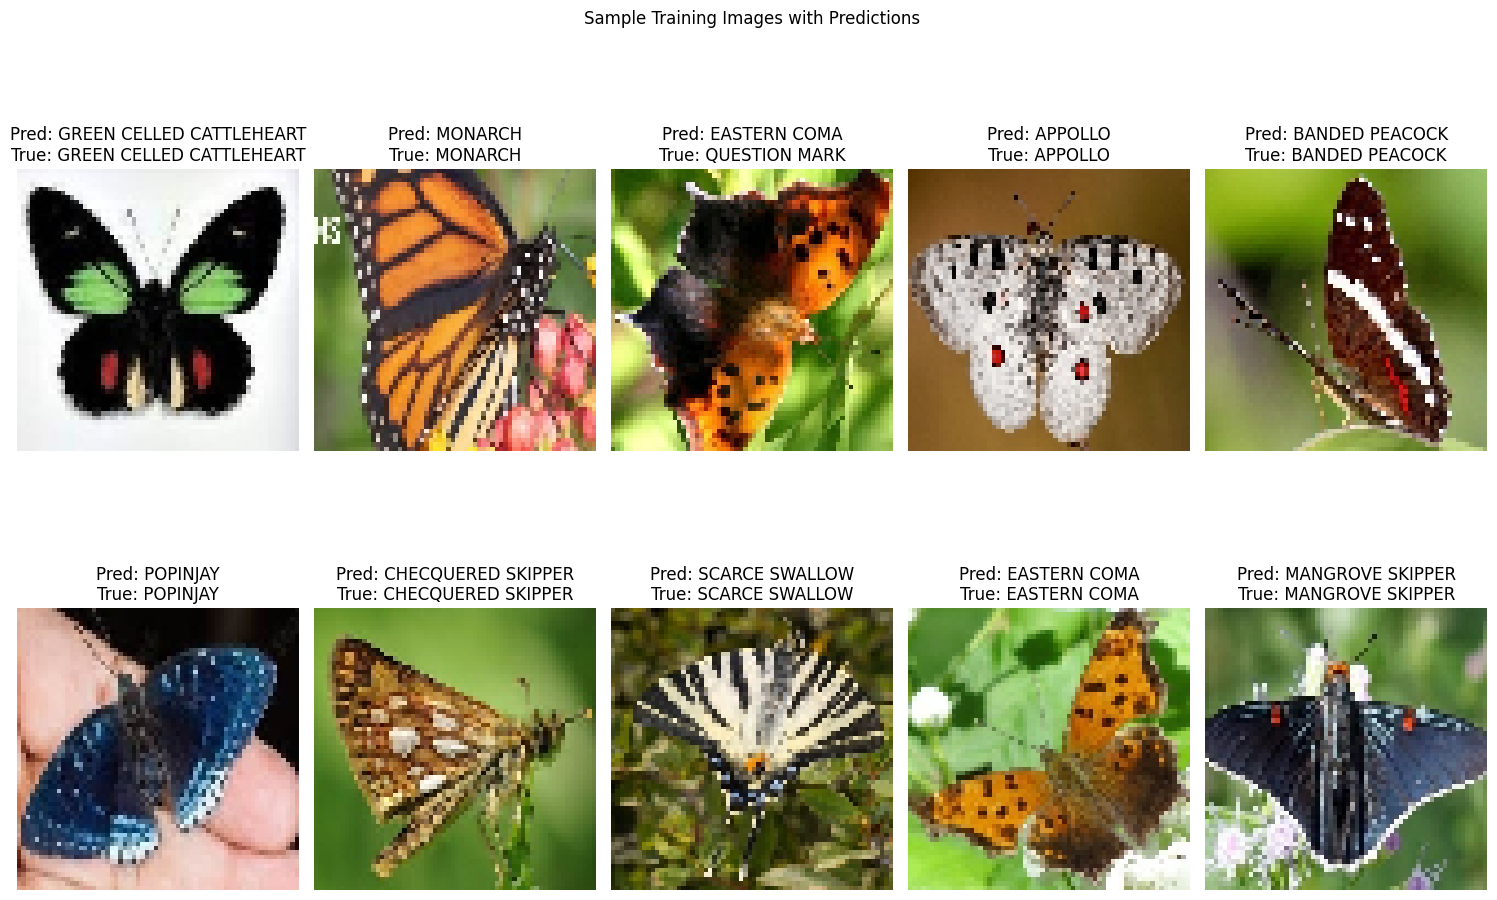

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use a sample from the training set to display predictions with true labels
sample_train = df_train.sample(num_images_to_predict, random_state=42)

# Load the actual images for the sampled training data
sample_images = []
true_labels_class_names = []
for index, row in sample_train.iterrows():
    img_path = os.path.join("/content/dataset", "train", row['filename'])
    img = load_img(img_path, target_size=(image_size, image_size))
    img = img_to_array(img) / 255.0
    sample_images.append(img)
    true_labels_class_names.append(row['label'])

sample_images = np.array(sample_images)


# 1. Make predictions on the sampled training images.
predictions = model.predict(sample_images)


# 2. Display the images and their predicted labels.
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(2, 5, i + 1)
    # Display the image
    plt.imshow(sample_images[i])

    # Get the predicted class index and convert to class name
    predicted_class_index = np.argmax(predictions[i])
    predicted_class_name = encoder.inverse_transform([predicted_class_index])[0]

    # Get the true class name
    true_class_name = true_labels_class_names[i]


    plt.title(f"Pred: {predicted_class_name}\nTrue: {true_class_name}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Sample Training Images with Predictions", y=1.02)
plt.show()